The most common example of a system that exhibits chaos is the double pendulum. In the double pendulum setting we know that small perturbations to the initial conditions significantly influence the trajectory. How best can we capture such changes?

The lagrangian of a system is:

$$ L = T(q,\dot{q}) - V(q) $$ and $$ \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = \tau$$

gives us the Euler-Lagrange equation with generalized forces

If $ T = \dot{q}^T M(q) \dot{q} $ and V is only a function of q, then:

$$ \frac{\partial L}{\partial \dot{q}} = p = M(q)\dot{q}$$

$$ \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} = \frac{dp}{dt} = \dot{M(q)}\dot{q} + M(q)\ddot{q} $$

Then,if we have no generalized forces:

$$\dot{M(q)}\dot{q} + M(q)\ddot{q} - \frac{\partial L}{\partial q} = 0 $$

$$ \ddot{q} = M(q)^{-1} (\frac{\partial L}{\partial q} - \dot{M(q)} \dot{q}) $$

Deep Lagrangian Nets https://arxiv.org/pdf/1907.04490.pdf - solves the above equation by learning each component and breaking the lagrangian L into a lower triangular times its transpose.

One unique aspect about VIGN is that we don't need to explicitly model the time derivative of M which is a bottle neck of the approach given above. so:

Given $[q_t,\dot{q_t}]$ $\rightarrow$ L $\rightarrow [p_t,\dot{p_t}] $ so now the state is basically:

given our initial state, we want to be able to update $[q_t,\dot{q_t}]$, the way to do this is:

$$ dq_t/dt = \dot{q_t}$$
$$ dp_t/dt = dL/dq $$

$$[q_{t+1},p_{t+1}] $$, but, if we learn M(q) then $$[q_{t+1},M^{-1}(q_{t+1})p_{t+1})]$$

***

In [1]:
from data_builder import *
from utils import *
from model import *
import numpy as np
import time

In [14]:
expt_name = 'test'
num_trajectories = 1
n_test_traj = 1
num_nodes = 2
T_max = 10.01
dt = 0.01
srate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


train_data = doublepend( expt_name, num_trajectories, num_nodes, T_max, dt, srate, 0,yflag=False)
valid_data = doublepend( expt_name, n_test_traj, num_nodes, 2*T_max,dt,srate, 1,yflag=False)



cpu


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
x1,y1,x2,y2 = theta_to_cart(train_data['x'])
x1_t,y1_t,x2_t,y2_t = theta_to_cart(valid_data['x'])

In [17]:
import seaborn as sns

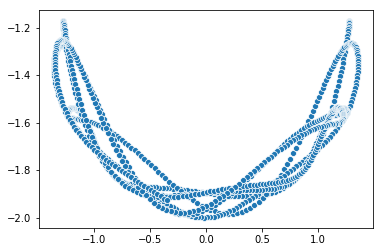

In [18]:
# sns.scatterplot(x=x1,y=y1)
sns.scatterplot(x=x2,y=y2)
# sns.scatterplot(x=x1,y=y1)
# sns.scatterplot(x=x2_t,y=y2_t)


In [19]:
tnow,tnext = nownext(train_data,num_trajectories,num_nodes,T_max,dt,srate,spatial_dim=2)

In [20]:

traindat = pendpixdata(tnow[0], tnext[0])
train_dataloader = DataLoader(traindat, batch_size=50, num_workers=2, shuffle=True)
# # valdat = pendpixdata(test_xnow, test_xnext)
# val_dataloader = DataLoader(valdat, batch_size=bs_test, num_workers=nw, shuffle=False)
data_dict = {'train': train_dataloader}
running_losses = 0.

def train_model(model, optimizer, num_epochs=1):

    for epoch in range(num_epochs):
        print('epoch:{}'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # Iterate over data.
            for batch_i, (q, dq) in enumerate(data_dict[phase]):
                if phase == 'train':
                    optimizer.zero_grad()
                q, next_step_true = q.float(), dq.float()
                q.to(device)
                next_step_true.to(device)
                q.requires_grad = True
                loss = 0
#                 print(q.shape)
                if phase == 'train':
                    t1 =time.time()
                    next_step_pred = model.next_step(q)
                    phat_via_m = ((model.M_matrix(q[:,:2]))@(q[:,2:].reshape(-1,1))).reshape(-1,2)
                    phat_via_l = model.Lpartials(q)[:,2:]
#                     print(f'running time next pred: {time.time()-t1}')
                    loss += ((next_step_pred - next_step_true) ** 2).mean() 
#                     loss += ((phat_via_m-phat_via_l)**2).mean()
                    (loss).backward()
                    optimizer.step()

                if phase == 'valid':
                    # print(q.shape)
                    t1 = time.time()
                    next_step_pred_roll = validator(deriv_fun, bs_test, q[0].reshape(-1, 2),ssr)
#                     print(f'running time validation: {time.time() - t1}')

                    loss += ((next_step_pred_roll - next_step_true) ** 2).mean()

                running_loss += loss.item()
            epoch_loss = running_loss
            print('{} Loss: {:.10f} Acc: {:.4f}'.format(phase, epoch_loss, 1))

    return model


model_ft = MODEL(4, 200, 1)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-3)
model_ft = train_model(model_ft, optimizer_ft, num_epochs=100)


epoch:0
train Loss: 0.0651154814 Acc: 1.0000
epoch:1
train Loss: 0.0597805192 Acc: 1.0000
epoch:2
train Loss: 0.0539244348 Acc: 1.0000
epoch:3
train Loss: 0.0361678299 Acc: 1.0000
epoch:4
train Loss: 0.0222486721 Acc: 1.0000
epoch:5
train Loss: 0.0150681885 Acc: 1.0000
epoch:6
train Loss: 0.0125182782 Acc: 1.0000
epoch:7
train Loss: 0.0103253095 Acc: 1.0000
epoch:8
train Loss: 0.0086320686 Acc: 1.0000
epoch:9
train Loss: 0.0071688133 Acc: 1.0000
epoch:10
train Loss: 0.0059448603 Acc: 1.0000
epoch:11
train Loss: 0.0056213892 Acc: 1.0000
epoch:12
train Loss: 0.0057207440 Acc: 1.0000
epoch:13
train Loss: 0.0051732183 Acc: 1.0000
epoch:14
train Loss: 0.0051653455 Acc: 1.0000
epoch:15
train Loss: 0.0049837205 Acc: 1.0000
epoch:16
train Loss: 0.0048231105 Acc: 1.0000
epoch:17
train Loss: 0.0046051803 Acc: 1.0000
epoch:18
train Loss: 0.0043421945 Acc: 1.0000
epoch:19
train Loss: 0.0040854807 Acc: 1.0000
epoch:20
train Loss: 0.0038198108 Acc: 1.0000
epoch:21
train Loss: 0.0034762501 Acc: 1.000

In [9]:
q=torch.tensor(tnow[0][0]).float().reshape(-1,4)
q.to(device)
q.requires_grad = True
loss = 0
coll = []
for _ in range(1000):
    nstep = model_ft.next_step(q)
    coll.append(nstep.detach().numpy()[0])
    q=nstep
    
                    

KeyboardInterrupt: 

In [10]:
x1_p,y1_p,x2_p,y2_p = theta_to_cart(np.array(coll))

In [11]:
x1_p.shape

(659,)

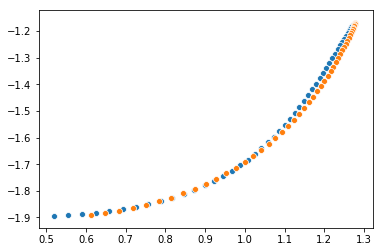

In [13]:
sns.scatterplot(x=x2_p[:50],y=y2_p[:50])
sns.scatterplot(x=x2[:50],y=y2[:50])

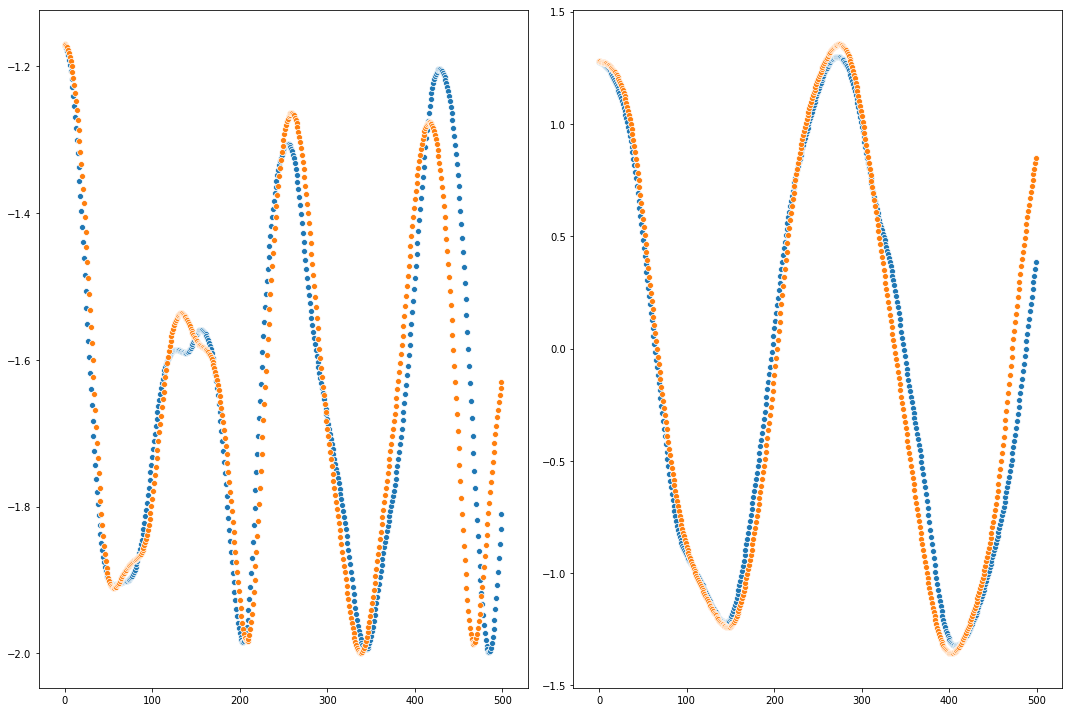

In [21]:

N = 500
fig,axs = plt.subplots(1,2,figsize=(15,10))
sns.scatterplot(x=range(N),y=y2_p[:N],ax=axs[0])
sns.scatterplot(x=range(N),y=y2[:N],ax=axs[0])
sns.scatterplot(x=range(N),y=x2_p[:N],ax=axs[1])
sns.scatterplot(x=range(N),y=x2[:N],ax=axs[1])
plt.tight_layout()

In [42]:
x2.shape

(1001,)

In [18]:
torch.pi

3.1415927410125732

In [19]:
np.pi

3.141592653589793

In [25]:
for batch_i, (q, dq) in enumerate(data_dict['train']):
    print(batch_i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [27]:
model_ft.M_matrix(q[:,:2].float())

tensor([[0.3456, 0.1160, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0865, 0.2030, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3641,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2045, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3817, 0.0579],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1108, 0.2447]],
       grad_fn=<ViewBackward>)

In [28]:
model_ft.Minv

tensor([[ 3.3763, -1.9295,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.4393,  5.7496,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  3.0443,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  5.9145,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  2.8132, -0.6653],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.2743,  4.3884]],
       grad_fn=<InverseBackward>)

In [31]:
torch.inverse(model_ft.M[:2,:2])

tensor([[ 3.3763, -1.9295],
        [-1.4393,  5.7496]], grad_fn=<InverseBackward>)